# Trabajo Práctico 6 - Procesamiento de Lenguaje Natural

## Asociación de palabras

### 1. Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccionario (<DOCNO>:<TEXT>)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from urllib import request
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from io import StringIO
import xml.etree.ElementTree as etree



nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/nico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nico/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/nico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
diccionario = {}
with open('ap.txt', 'rb') as apfile:

    ap89_plain = apfile.read().decode('utf-8')

    ap89_plain = '<DOCS>\n' + ap89_plain + '</DOCS>\n'
    ap89_plain = ap89_plain.replace('&', '&#038;')
    ap89_IO = StringIO(ap89_plain)
    tree = etree.parse(ap89_IO)
    root = tree.getroot()
    
    for child in root:
        diccionario[child[0].text] = child[1].text



In [3]:
def gwp(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [4]:
def limpiar(t):
    stop = set(stopwords.words('english'))
    
    sent = nltk.sent_tokenize(t) # separar en oraciones
    
    tokenizer = RegexpTokenizer("[\w']+")
    l = []
    for s in map(tokenizer.tokenize, sent): # sacar stopwords
        l.append([word for word in s if word not in stop])
     
    wl = WordNetLemmatizer()
    r = []
    importantes = ['J', 'V', 'N', 'R']
    for s in map(nltk.pos_tag, l): # filtramos palabras importantes y con una longitud mayor a dos
        r.append([wl.lemmatize(w, pos=gwp(t)) for (w, t) in s if w != t and len(w)>2 and t[0] in importantes] )
      
    return [item for l in r for item in l]

palabras = []
for noticia in diccionario.values():
    for word in limpiar(noticia):
        palabras.append(word)


### 2. Calcular el tamaño del vocabulario.

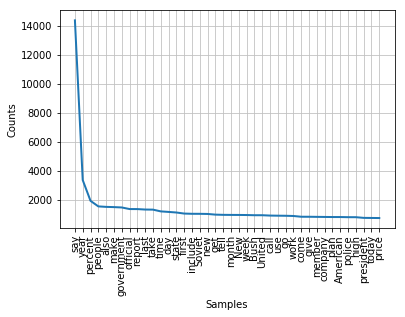

In [22]:
from nltk import FreqDist
Freq=FreqDist(palabras)
FreqDist(palabras).plot(40, cumulative=False)

In [5]:
#from itertools import groupby

#freq = {}
#for palabra in set(palabras):
#        freq[palabra] = palabras.count(palabra)

In [20]:
print('Tamaño del vocabulario: ' + str(len(Freq)))

Tamaño del vocabulario: 36374


In [7]:
#most_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)[0:500]
#print (most_freq)

### 3. Para las 500 palabras con más apariciones, calcular el par más asociado según la medida presentada.

In [27]:
# Se buscan los pares de palabras más asociados dentro de todo el texto 
from nltk.collocations import *
bigram_measures= nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(palabras,3)
finder.apply_freq_filter(3)
scored = finder.nbest(bigram_measures.pmi,20)
print(scored)

[('Cam', 'Ranh'), ('Chi', 'Chi'), ('Cordon', 'Bleu'), ('Croatia', 'Slovenia'), ('Doo', 'hwan'), ('Gazeta', 'Wyborcza'), ('Guess', 'Jeans'), ('JNB', 'Exploration'), ('Novaya', 'Zemlya'), ('Nueva', 'Vizcaya'), ('Palmieri', 'Billig'), ('Palo', 'Alto'), ('Tan', 'Ching'), ('Term', 'Strategy'), ('Yasuhiro', 'Nakasone'), ('Yom', 'Kippur'), ('avant', 'garde'), ('Adventures', 'Munchausen'), ('Coeur', "d'Alene"), ('Coral', 'Gables')]


## Información Léxica
Bajar de Project Gutenberg el libro de Darwin ON THE ORIGIN OF SPECIES.


### 1. Procesar el texto, tokenizando eliminando signos de puntuación.

In [2]:
# descargamos el libro
url = "http://www.gutenberg.org/cache/epub/1228/pg1228.txt"
response = request.urlopen(url)
raw = response.read().decode('utf8')

In [3]:
#se recortará el documento de forma tal que sólo quede el contenido de los distintos capítulos
inicio=raw.rfind("INTRODUCTION.") #aquí comenzaría
fin=raw.rfind("INDEX.") #aquí terminaría

#se tokenizará el texto y se eliminarán los signos de puntuación
tokenizer = RegexpTokenizer(r'\w+')
texto = tokenizer.tokenize(raw[inicio:fin])

### 2. Siguiendo el artículo de la sección, calcular la autocorrelación para estimar la distribución de la palabra a lo largo del texto.

In [4]:
def get_words_index(texto, words):
    """ texto: lista de palabras
        words: lista de palabras a buscar en texto
        
        Para el texto, devolver un diccionario
        {word: [indice]} donde word es cada una de los elementos
        de words e [indice] es una lista de posiciones en donde ocurre
        la palabra en el texto
    """
    
    r = {w: [] for w in words}
    i = 1
    for palabra in texto:
        if palabra in words:
            r[palabra].append(i)
        i = i + 1
    
    return r

In [5]:
def P(p_index, t):
    """ p_index: posiciones de la palabra en el texto
        t: posicion en el texto para el calculo de p
    """
    sigma = 50
    c = 1 / np.sqrt(2 * np.pi)
    z = -1/(2*sigma*sigma)
    
    r = c*np.sum(np.exp(np.multiply(np.square(np.subtract(t, p_index)), z)))
    
    return r

In [6]:
# Calculo los P para cada posicion del texto para cada palabra

index = get_words_index(texto, ['plants', 'instinct', 'for'])

N = len(texto)
p = {w: [] for w in index.keys()}

for word in index.keys():
    for t in range(1, N+1):
        p[word].append(P(index[word], t))

In [7]:
def c(pw, tau):
    """pw: P aplicado a todas las posiciones de un texto para una palabra
    
        devuelve la autocorrelacion normalizada 
    """
    N = len(pw)
    Epptau = np.mean(np.multiply(pw[0:N-tau], pw[tau:]))
    EpEptau = np.mean(pw) * np.mean(pw[tau:])
    return (Epptau - EpEptau) / (np.mean(np.square(pw)) - (np.square(np.mean(pw)))) 

In [26]:
#type(np.mean(p['plants']))
words = ['plants', 'instinct', 'for']
cs = {w: [] for w in words}
dominio = np.arange(0, 10000, 10)

for palabra in words:
    for tau in dominio:
        cs[palabra].append(c(p[palabra], tau))

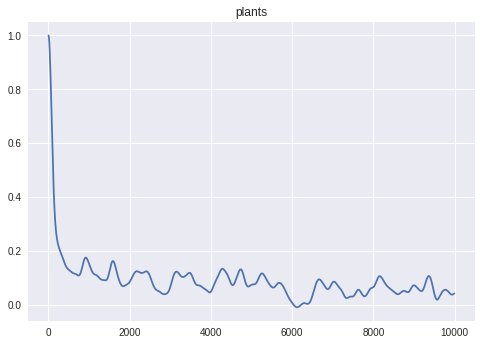

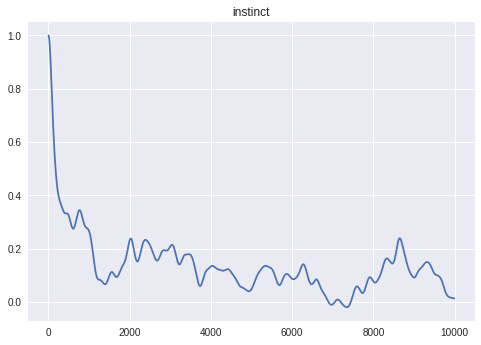

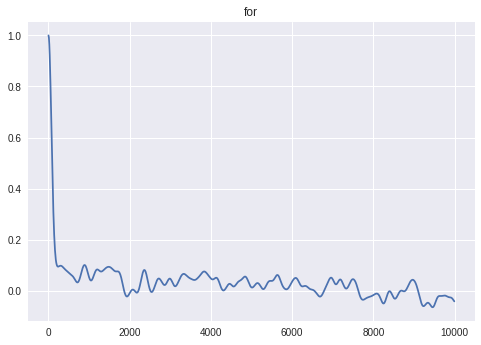

In [30]:
for palabra in words:
    plt.plot(dominio, cs[palabra])
    plt.title(palabra)
    plt.show()

### 3. Calcular la entropı́a de una selección de 100 palabras que abarquen el rango de frecuencia de aparición en el libro, es decir elegir palabras que son muy frecuentes y otras de baja frecuencia.

## Word embeddings, distancia semántica y WordNet
1. Utilizando el test WordSim3531, comparar el rendimiento entre LSA y Word2Vec2.
2. Comparar los distintos word embeddings con las medidas definidas en WordNet. 